## Практическая работа №6

1. В приложенном датасете собраны данные о результатах экзаменов студентов. Создайте из него числовой датасет.
2. Разделите полученный датасет на обучающую и тестовую часть в пропорции 70/30
3. Постройте три модели линейной регрессии для предсказания каждого из трех результатов экзаменов. Сделайте это в двух предположениях: 
     - результат экзамена не зависит от результатов уже прошедших экзаменов;
     - результат экзамена зависит от результатов уже прошедших экзаменов.
4. Вычислите R-квадрат для каждого предсказания.
5. Сделайте выводы о качестве прогноза соответственно предположениям.

In [1]:
# =============================================================================
# ИМПОРТ БИБЛИОТЕК И ЗАГРУЗКА ДАННЫХ
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Функция для загрузки данных из CSV файла
def load_exam_data(file_path):
    """
    Загружает данные об экзаменационных результатах из CSV файла
    
    Параметры:
    file_path - путь к файлу с данными
    
    Возвращает:
    Список словарей с исходными данными
    """
    data_records = []  # Список для хранения данных
    # Названия колонок для нашего датасета
    column_names = ["gender", "ethnicity", "parent_education", "lunch", "prep_course", "math", "reading", "writing"]
    
    # Открываем файл и читаем данные
    with open(file_path, 'r', encoding='utf-8') as file:
        headers = file.readline().strip().split(',')  # Читаем заголовки
        
        # Обрабатываем каждую строку данных
        for line in file:
            values = line.strip().split(',')  # Разбиваем строку на значения
            
            # Создаем запись с данными
            record = {
                column_names[0]: values[0],    # gender - пол
                column_names[1]: values[1],    # ethnicity - раса/этническая принадлежность  
                column_names[2]: values[2],    # parent_education - образование родителей
                column_names[3]: values[3],    # lunch - тип питания
                column_names[4]: values[4],    # prep_course - подготовительные курсы
                column_names[5]: int(values[5]),  # math - балл по математике
                column_names[6]: int(values[6]),  # reading - балл по чтению
                column_names[7]: int(values[7])   # writing - балл по письму
            }
            data_records.append(record)
    
    return data_records

# Загружаем исходные данные
raw_data = load_exam_data("exams - exams.csv")
print(f"Загружено записей: {len(raw_data)}")
print("Пример первой записи:", raw_data[0])

Загружено записей: 1000
Пример первой записи: {'gender': 'female', 'ethnicity': 'group D', 'parent_education': 'some college', 'lunch': 'standard', 'prep_course': 'completed', 'math': 59, 'reading': 70, 'writing': 78}


In [2]:
# =============================================================================
# ПРЕОБРАЗОВАНИЕ КАТЕГОРИАЛЬНЫХ ДАННЫХ В ЧИСЛОВЫЕ
# =============================================================================

# Словари для преобразования категориальных данных в числовые
conversion_maps = {
    "gender": {"female": 0, "male": 1},  # Пол: женский=0, мужской=1
    "ethnicity": {  # Этническая принадлежность: группы A-E
        "group A": 0, 
        "group B": 1, 
        "group C": 2, 
        "group D": 3, 
        "group E": 4
    },
    "parent_education": {  # Образование родителей
        "some high school": 0,      # Неоконченная средняя школа
        "high school": 1,           # Средняя школа
        "some college": 2,          # Неоконченный колледж
        "associate's degree": 3,    # Степень ассоциата
        "bachelor's degree": 4,     # Бакалавриат
        "master's degree": 5        # Магистратура
    },
    "lunch": {"standard": 0, "free/reduced": 1},  # Питание: стандартное=0, льготное=1
    "prep_course": {"none": 0, "completed": 1}    # Подготовка: не проходил=0, прошел=1
}

# Функция для преобразования категориальных данных в числовые
def convert_to_numeric(data):
    """
    Преобразует категориальные данные в числовые используя словари преобразования
    
    Параметры:
    data - исходные данные с категориальными признаками
    
    Возвращает:
    Данные с числовыми признаками
    """
    numeric_data = []
    
    for record in data:
        converted_record = {}
        # Преобразуем категориальные признаки используя словари
        converted_record["gender"] = conversion_maps["gender"][record["gender"]]
        converted_record["ethnicity"] = conversion_maps["ethnicity"][record["ethnicity"]]
        converted_record["parent_education"] = conversion_maps["parent_education"][record["parent_education"]]
        converted_record["lunch"] = conversion_maps["lunch"][record["lunch"]]
        converted_record["prep_course"] = conversion_maps["prep_course"][record["prep_course"]]
        # Числовые признаки (баллы) оставляем как есть
        converted_record["math"] = record["math"]
        converted_record["reading"] = record["reading"] 
        converted_record["writing"] = record["writing"]
        numeric_data.append(converted_record)
    
    return numeric_data

# Преобразуем данные
numeric_data = convert_to_numeric(raw_data)
print("Категориальные данные преобразованы в числовые")
print("Пример преобразованной записи:", numeric_data[0])

Категориальные данные преобразованы в числовые
Пример преобразованной записи: {'gender': 0, 'ethnicity': 3, 'parent_education': 2, 'lunch': 0, 'prep_course': 1, 'math': 59, 'reading': 70, 'writing': 78}


In [3]:
# =============================================================================
# НОРМАЛИЗАЦИЯ ДАННЫХ
# =============================================================================

# Функция для нормализации данных в диапазон [0, 1]
def normalize_data(data):
    """
    Нормализует данные в диапазон [0, 1] используя мин-макс нормализацию
    """
    # Собираем статистику по каждому признаку
    stats = {}
    for key in data[0].keys():  # Для каждого признака
        values = []
        for item in data:
            values.append(item[key])  # Собираем все значения признака
        
        # Сохраняем мин и макс для признака
        stats[key] = {
            'min': min(values),
            'max': max(values)
        }
    
    # Нормализуем данные
    normalized_data = []
    for record in data:  # Для каждой записи
        normalized_record = {}
        for key, value in record.items():  # Для каждого признака в записи
            min_val = stats[key]['min'] # Получаем минимальное значение для текущего признака
            max_val = stats[key]['max'] # Получаем максимальное значение для текущего признака
            
            # Применяем формулу нормализации
            if max_val != min_val:
                 # Применяем формулу мин-макс нормализации: (значение - мин) / (макс - мин)
                normalized_record[key] = (value - min_val) / (max_val - min_val)
            else:
                normalized_record[key] = 0.5  # Если все значения одинаковы
        
        normalized_data.append(normalized_record)
    
    return normalized_data

# Нормализуем данные
normalized_data = normalize_data(numeric_data)
print("Данные нормализованы в диапазон [0, 1]")
print("Пример нормализованной записи:", normalized_data[0])

# Выводим статистику по нормализованным данным
print("\nСтатистика нормализованных данных:")
for key in normalized_data[0].keys():
    values = []
    for item in normalized_data:
        values.append(item[key])
    
    # Выводим мин, макс и среднее для каждого признака
    print(f"{key}: min={min(values):.4f}, max={max(values):.4f}, mean={np.mean(values):.4f}")

Данные нормализованы в диапазон [0, 1]
Пример нормализованной записи: {'gender': 0.0, 'ethnicity': 0.75, 'parent_education': 0.4, 'lunch': 0.0, 'prep_course': 1.0, 'math': 0.5176470588235295, 'reading': 0.6, 'writing': 0.7411764705882353}

Статистика нормализованных данных:
gender: min=0.0000, max=1.0000, mean=0.5080
ethnicity: min=0.0000, max=1.0000, mean=0.5467
parent_education: min=0.0000, max=1.0000, mean=0.4140
lunch: min=0.0000, max=1.0000, mean=0.3400
prep_course: min=0.0000, max=1.0000, mean=0.3440
math: min=0.0000, max=1.0000, mean=0.6213
reading: min=0.0000, max=1.0000, mean=0.6051
writing: min=0.0000, max=1.0000, mean=0.6369


In [4]:
# =============================================================================
# РАЗДЕЛЕНИЕ ДАННЫХ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ
# =============================================================================

# Разделяем данные в пропорции 70/30
split_index = int(len(normalized_data) * 0.7)
train_data = normalized_data[:split_index]  # Первые 70% данных - обучающая выборк
test_data = normalized_data[split_index:] # Последние 30% данных - тестовая выборка

print(f"Общее количество записей: {len(normalized_data)}")
print(f"Обучающая выборка: {len(train_data)} записей ({len(train_data)/len(normalized_data)*100:.1f}%)")
print(f"Тестовая выборка: {len(test_data)} записей ({len(test_data)/len(normalized_data)*100:.1f}%)")

# Проверяем что разделение корректно
assert len(train_data) + len(test_data) == len(normalized_data), "Ошибка при разделении данных"
print("\nРазделение данных выполнено успешно")

Общее количество записей: 1000
Обучающая выборка: 700 записей (70.0%)
Тестовая выборка: 300 записей (30.0%)

Разделение данных выполнено успешно


**Условие регрессии:**

**ŷᵢ = α + ∑ βₖxᵢₖ**


In [5]:
# =============================================================================
# ФУНКЦИИ ДЛЯ МНОЖЕСТВЕННОЙ ЛИНЕЙНОЙ РЕГРЕССИИ
# =============================================================================

def dot(u, v):
    """Скалярное произведение двух векторов"""
    result = 0  # Инициализируем результат
    for i in range(len(u)):  # Проходим по всем элементам векторов
        result += u[i] * v[i]  # Умножаем соответствующие элементы и добавляем к результату
    return result  # Возвращаем скалярное произведение

def gauss(M, b):
    """Решение системы линейных уравнений методом Гаусса"""
    n = len(M)  # Получаем размер системы (количество уравнений)
    # Создаем расширенную матрицу [M|b]
    for i in range(n):  # Проходим по всем строкам матрицы
        M[i].append(b[i])  # Добавляем элемент вектора b в конец строки
    
    # Прямой ход метода Гаусса - приведение к верхнетреугольному виду
    for i in range(n):  # Проходим по всем диагональным элементам
        # Поиск максимального элемента в столбце (выбор главного элемента)
        max_el = abs(M[i][i])  # Текущий максимальный элемент
        max_row = i  # Строка с максимальным элементом
        for k in range(i+1, n):  # Ищем в столбце ниже текущей строки
            if abs(M[k][i]) > max_el:  # Если нашли больший элемент
                max_el = abs(M[k][i])  # Обновляем максимальный элемент
                max_row = k  # Запоминаем строку с максимальным элементом
        
        # Перестановка строк для устойчивости алгоритма
        temp = M[i]  # Сохраняем текущую строку
        M[i] = M[max_row]  # Заменяем текущую строку строкой с максимальным элементом
        M[max_row] = temp  # Восстанавливаем сохраненную строку на место максимальной
        
        # Обнуление элементов ниже диагонали
        for k in range(i+1, n):  # Проходим по всем строкам ниже текущей
            if M[i][i] == 0:  # Если диагональный элемент нулевой - пропускаем
                continue
            c = -M[k][i] / M[i][i]  # Вычисляем коэффициент для обнуления
            for j in range(i, n+1):  # Проходим по всем элементам строки начиная с диагонали
                if i == j:  # Если это диагональный элемент
                    M[k][j] = 0  # Обнуляем элемент под диагональю
                else:  # Для остальных элементов
                    M[k][j] = M[k][j] + c * M[i][j]  # Выполняем линейную комбинацию строк
    
    # Обратный ход - нахождение решения системы
    x = [0] * n  # Инициализируем вектор решений
    for i in range(n-1, -1, -1):  # Проходим снизу вверх от последней строки к первой
        if M[i][i] == 0:  # Если диагональный элемент нулевой
            x[i] = 0  # Устанавливаем решение в 0
        else:  # Если диагональный элемент ненулевой
            x[i] = M[i][n] / M[i][i]  # Находим решение для i-й переменной
            for k in range(i-1, -1, -1):  # Проходим по строкам выше текущей
                M[k][n] = M[k][n] - M[k][i] * x[i]  # Подставляем найденное решение в вышестоящие уравнения
    
    return x  # Возвращаем вектор решений [β₀, β₁, ..., βₘ₋₁, α]

def regression(X, y):
    """
    Множественная линейная регрессия по методу наименьших квадратов
    X - список из m векторов (признаков)
    y - вектор целевой переменной
    Возвращает коэффициенты [β₀, β₁, ..., βₘ₋₁, α]
    """
    m = len(X)  # Количество признаков (размерность задачи)
    n = len(y)  # Количество наблюдений (размер выборки)
    
    M = []  # Инициализируем матрицу системы уравнений
    b = []  # Инициализируем вектор правой части
    
    # Первое уравнение системы из методички:
    # β₀Σxᵢ₀ + ... + βₘ₋₁Σxᵢₘ₋₁ + nα = Σyᵢ
    
    # Создаем первую строку матрицы, которая содержит коэффициенты при [β₀, β₁, β₂, ..., βₘ₋₁, α]
    first_row = []  # [Σпризнак₀, Σпризнак₁, Σпризнак₂, ..., Σпризнакₘ₋₁, n]
    for k in range(m):  # Проходим по всем признакам
        first_row.append(sum(X[k]))  # Добавляем сумму k-го признака Σxᵢₖ
    first_row.append(n)  # Добавляем n (коэффициент при α)
    M.append(first_row)  # Добавляем первую строку в матрицу
    b.append(sum(y))  # Добавляем сумму целевой переменной Σyᵢ в правую часть

    
    # Остальные уравнения системы из методички:
    # β₀Σxᵢ₀xᵢₗ + ... + βₘ₋₁Σxᵢₘ₋₁xᵢₗ + αΣxᵢₗ = Σyᵢxᵢₗ, l=0,...,m-1
    
    for l in range(m):  # Проходим по всем признакам для создания m уравнений
        row = []  # Создаем новую строку матрицы
        for k in range(m):  # Проходим по всем признакам для текущего уравнения
            row.append(dot(X[k], X[l]))  # Добавляем скалярное произведение Σxᵢₖxᵢₗ
        row.append(sum(X[l]))  # Добавляем сумму l-го признака Σxᵢₗ (коэффициент при α)
        M.append(row)  # Добавляем строку в матрицу
        b.append(dot(y, X[l]))  # Добавляем скалярное произведение Σyᵢxᵢₗ в правую часть
    
    return gauss(M, b)  # Решаем систему уравнений и возвращаем коэффициенты [β₀, β₁, ..., βₘ₋₁, α]

def mult_predict(x_i, beta):
    """Прогноз для одного наблюдения (по методичке)"""
    # x_i - вектор признаков одного наблюдения
    # beta - коэффициенты [β₀, β₁, ..., βₘ₋₁, α]
    result = beta[-1]  # Начинаем со свободного члена α (последний элемент в beta)
    for j in range(len(x_i)):  # Проходим по всем признакам наблюдения
        result = result + beta[j] * x_i[j]  # Добавляем βⱼ * xᵢⱼ для каждого признака
    return result  # Возвращаем прогноз: 𝑦̂𝑖 = α + Σβₖxᵢₖ

def mult_error(x_i, y_i, beta):
    """Ошибка предсказания (по методичке)"""
    return mult_predict(x_i, beta) - y_i  # Возвращаем разность: прогноз - фактическое значение

def total_sum_of_squares(y):
    """Общая сумма квадратов (по методичке)"""
    y_mean = sum(y) / len(y)  # Вычисляем среднее значение целевой переменной
    total = 0  # Инициализируем сумму квадратов
    for i in range(len(y)):  # Проходим по всем наблюдениям
        total = total + (y[i] - y_mean) ** 2  # Добавляем квадрат отклонения от среднего
    return total  # Возвращаем общую сумму квадратов: Σ(yᵢ - ȳ)²

def mult_r_squared(x, y, beta):
    """
    Коэффициент детерминации R² 
    x - список наблюдений, каждый элемент - вектор признаков
    y - вектор целевых значений  
    beta - коэффициенты модели
    """
    sum_of_squared_errors = 0  # Инициализируем сумму квадратов ошибок
    for i in range(len(y)):  # Проходим по всем наблюдениям
        error_val = mult_error(x[i], y[i], beta)  # Вычисляем ошибку для i-го наблюдения
        sum_of_squared_errors = sum_of_squared_errors + error_val ** 2  # Добавляем квадрат ошибки к сумме
    # Вычисляем R² по формуле: 1 - (SSE / SST)
    return 1.0 - sum_of_squared_errors / total_sum_of_squares(y)  # Возвращаем коэффициент детерминации

def prepare_data_for_regression(dataset, input_features):
    """
    Подготавливает данные в формате методички для функции regression()
    Возвращает:
    X - список векторов признаков (каждый вектор - значения одного признака для всех наблюдений)
    """
    n = len(dataset)  # Количество наблюдений в датасете
    m = len(input_features)  # Количество признаков для регрессии
    
    X = []  # Инициализируем список для признаков
    for i in range(m):  # Создаем m пустых списков для каждого признака
        X.append([])  # Добавляем пустой список для i-го признака
    
    for record in dataset:  # Проходим по всем наблюдениям в датасете
        for j in range(m):  # Проходим по всем признакам
            feature = input_features[j]  # Получаем имя j-го признака
            X[j].append(record[feature])  # Добавляем значение признака в соответствующий список
    
    return X  # Возвращаем X в формате: [ [все_значения_признака_0], [все_значения_признака_1], ... ]

def prepare_data_for_evaluation(dataset, input_features, target_feature):
    """
    Подготавливает данные для вычисления R-квадрата
    Возвращает:
    x - список наблюдений (каждый элемент - вектор признаков) [ [признаки_студента_0], [признаки_студента_1], ... ]
    y - вектор целевых значений
    """
    x = []  # Инициализируем список для векторов признаков наблюдений
    y = []  # Инициализируем список для целевых значений
    
    for record in dataset:  # Проходим по всем наблюдениям в датасете
        # Создаем вектор признаков для одного наблюдения
        x_i = []  # Инициализируем вектор признаков текущего наблюдения
        for feature in input_features:  # Проходим по всем входным признакам
            x_i.append(record[feature])  # Добавляем значение признака в вектор
        x.append(x_i)  # Добавляем вектор признаков в список наблюдений
        y.append(record[target_feature])  # Добавляем целевое значение в список целей
    
    return x, y  # Возвращаем данные в формате для mult_r_squared()

print("Все функции для множественной линейной регрессии определены")

Все функции для множественной линейной регрессии определены


In [6]:
# =============================================================================
# ОБУЧЕНИЕ МОДЕЛЕЙ ДЛЯ ПЕРВОГО ПРЕДПОЛОЖЕНИЯ
# (экзамены не зависят от результатов уже прошедших экзаменов)
# =============================================================================

print("ОБУЧЕНИЕ МОДЕЛЕЙ ДЛЯ ПЕРВОГО ПРЕДПОЛОЖЕНИЯ")
print("(экзамены не зависят от результатов уже прошедших экзаменов)")
print("=" * 70)

# Определяем наборы признаков, которые будут использоваться для предсказания всех экзаменов
features_basic = ["gender", "ethnicity", "parent_education", "lunch", "prep_course"]

print("\n1. МОДЕЛЬ ДЛЯ МАТЕМАТИКИ (только базовые признаки):")
# Подготавливаем данные в формате для regression()
X_train = prepare_data_for_regression(train_data, features_basic)
y_train = []
for record in train_data:
    y_train.append(record["math"]) # баллы по математике всех студентов обучающей выборки
# Обучаем модель
beta_math_1 = regression(X_train, y_train)
print(f"   Коэффициенты: {[f'{c:.4f}' for c in beta_math_1]}")
print(f"   α (свободный член): {beta_math_1[-1]:.4f}")

print("\n2. МОДЕЛЬ ДЛЯ ЧТЕНИЯ (только базовые признаки):")
X_train = prepare_data_for_regression(train_data, features_basic)
y_train = []
for record in train_data:
    y_train.append(record["reading"]) # баллы по чтению всех студентов обучающей выборки
beta_reading_1 = regression(X_train, y_train)
print(f"   Коэффициенты: {[f'{c:.4f}' for c in beta_reading_1]}")
print(f"   α (свободный член): {beta_reading_1[-1]:.4f}")

print("\n3. МОДЕЛЬ ДЛЯ ПИСЬМА (только базовые признаки):")
X_train = prepare_data_for_regression(train_data, features_basic)
y_train = []
for record in train_data:
    y_train.append(record["writing"]) # баллы по письму всех студентов обучающей выборки
beta_writing_1 = regression(X_train, y_train)
print(f"   Коэффициенты: {[f'{c:.4f}' for c in beta_writing_1]}")
print(f"   α (свободный член): {beta_writing_1[-1]:.4f}")

print("\nОбучение моделей для первого предположения завершено")

ОБУЧЕНИЕ МОДЕЛЕЙ ДЛЯ ПЕРВОГО ПРЕДПОЛОЖЕНИЯ
(экзамены не зависят от результатов уже прошедших экзаменов)

1. МОДЕЛЬ ДЛЯ МАТЕМАТИКИ (только базовые признаки):
   Коэффициенты: ['0.0683', '0.1401', '0.0852', '-0.1382', '0.0629', '0.4958']
   α (свободный член): 0.4958

2. МОДЕЛЬ ДЛЯ ЧТЕНИЯ (только базовые признаки):
   Коэффициенты: ['-0.0769', '0.1050', '0.0762', '-0.1032', '0.0927', '0.5549']
   α (свободный член): 0.5549

3. МОДЕЛЬ ДЛЯ ПИСЬМА (только базовые признаки):
   Коэффициенты: ['-0.0995', '0.1048', '0.0988', '-0.0995', '0.1242', '0.5774']
   α (свободный член): 0.5774

Обучение моделей для первого предположения завершено


In [7]:
# =============================================================================
# ОБУЧЕНИЕ МОДЕЛЕЙ ДЛЯ ВТОРОГО ПРЕДПОЛОЖЕНИЯ  
# (экзамены зависят от результатов уже прошедших экзаменов)
# =============================================================================

print("ОБУЧЕНИЕ МОДЕЛЕЙ ДЛЯ ВТОРОГО ПРЕДПОЛОЖЕНИЯ")
print("(экзамены зависят от результатов уже прошедших экзаменов)")
print("=" * 70)

# Определяем наборы признаков
features_with_math = features_basic + ["math"]
features_with_math_reading = features_basic + ["math", "reading"]

print("\n1. МОДЕЛЬ ДЛЯ МАТЕМАТИКИ (только базовые признаки):")
X_train = prepare_data_for_regression(train_data, features_basic)
y_train = []
for record in train_data:
    y_train.append(record["math"]) 
beta_math_2 = regression(X_train, y_train)
print(f"   Коэффициенты: {[f'{c:.4f}' for c in beta_math_2]}")

print("\n2. МОДЕЛЬ ДЛЯ ЧТЕНИЯ (базовые признаки + математика):")
X_train = prepare_data_for_regression(train_data, features_with_math)
y_train = []
for record in train_data:
    y_train.append(record["reading"])
beta_reading_2 = regression(X_train, y_train)
print(f"   Коэффициенты: {[f'{c:.4f}' for c in beta_reading_2]}")

print("\n3. МОДЕЛЬ ДЛЯ ПИСЬМА (базовые признаки + математика + чтение):")
X_train = prepare_data_for_regression(train_data, features_with_math_reading)
y_train = []
for record in train_data:
    y_train.append(record["writing"])
beta_writing_2 = regression(X_train, y_train)
print(f"   Коэффициенты: {[f'{c:.4f}' for c in beta_writing_2]}")

print("\nОбучение моделей для второго предположения завершено")

ОБУЧЕНИЕ МОДЕЛЕЙ ДЛЯ ВТОРОГО ПРЕДПОЛОЖЕНИЯ
(экзамены зависят от результатов уже прошедших экзаменов)

1. МОДЕЛЬ ДЛЯ МАТЕМАТИКИ (только базовые признаки):
   Коэффициенты: ['0.0683', '0.1401', '0.0852', '-0.1382', '0.0629', '0.4958']

2. МОДЕЛЬ ДЛЯ ЧТЕНИЯ (базовые признаки + математика):
   Коэффициенты: ['-0.1431', '-0.0308', '-0.0064', '0.0307', '0.0318', '0.9691', '0.0743']

3. МОДЕЛЬ ДЛЯ ПИСЬМА (базовые признаки + математика + чтение):
   Коэффициенты: ['-0.0719', '0.0028', '0.0293', '0.0009', '0.0508', '0.2750', '0.6045', '0.1056']

Обучение моделей для второго предположения завершено


In [8]:
# =============================================================================
# ВЫЧИСЛЕНИЕ R-КВАДРАТ ДЛЯ ВСЕХ МОДЕЛЕЙ
# =============================================================================

print("ВЫЧИСЛЕНИЕ R-КВАДРАТ ДЛЯ ВСЕХ МОДЕЛЕЙ")
print("=" * 70)

print("\n=== ПЕРВОЕ ПРЕДПОЛОЖЕНИЕ (независимые экзамены) ===")

# Подготавливаем тестовые данные для вычисления R-квадрата
x_test, y_test = prepare_data_for_evaluation(test_data, features_basic, "math")
r2_math_1 = mult_r_squared(x_test, y_test, beta_math_1)
print(f"R² для математики: {r2_math_1:.4f}")

x_test, y_test = prepare_data_for_evaluation(test_data, features_basic, "reading")
r2_reading_1 = mult_r_squared(x_test, y_test, beta_reading_1)
print(f"R² для чтения: {r2_reading_1:.4f}")



x_test, y_test = prepare_data_for_evaluation(test_data, features_basic, "writing")
r2_writing_1 = mult_r_squared(x_test, y_test, beta_writing_1)
print(f"R² для письма: {r2_writing_1:.4f}")

print("\n=== ВТОРОЕ ПРЕДПОЛОЖЕНИЕ (зависимые экзамены) ===")

x_test, y_test = prepare_data_for_evaluation(test_data, features_basic, "math")
r2_math_2 = mult_r_squared(x_test, y_test, beta_math_2)
print(f"R² для математики: {r2_math_2:.4f}")

x_test, y_test = prepare_data_for_evaluation(test_data, features_with_math, "reading")
r2_reading_2 = mult_r_squared(x_test, y_test, beta_reading_2)
print(f"R² для чтения: {r2_reading_2:.4f}")

x_test, y_test = prepare_data_for_evaluation(test_data, features_with_math_reading, "writing")
r2_writing_2 = mult_r_squared(x_test, y_test, beta_writing_2)
print(f"R² для письма: {r2_writing_2:.4f}")

ВЫЧИСЛЕНИЕ R-КВАДРАТ ДЛЯ ВСЕХ МОДЕЛЕЙ

=== ПЕРВОЕ ПРЕДПОЛОЖЕНИЕ (независимые экзамены) ===
R² для математики: 0.3027
R² для чтения: 0.2528
R² для письма: 0.3509

=== ВТОРОЕ ПРЕДПОЛОЖЕНИЕ (зависимые экзамены) ===
R² для математики: 0.3027
R² для чтения: 0.8213
R² для письма: 0.9417


ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ И ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ

=== ОЦЕНКА МОДЕЛЕЙ ПЕРВОГО ПРЕДПОЛОЖЕНИЯ ===

1. МАТЕМАТИКА - Независимая модель:


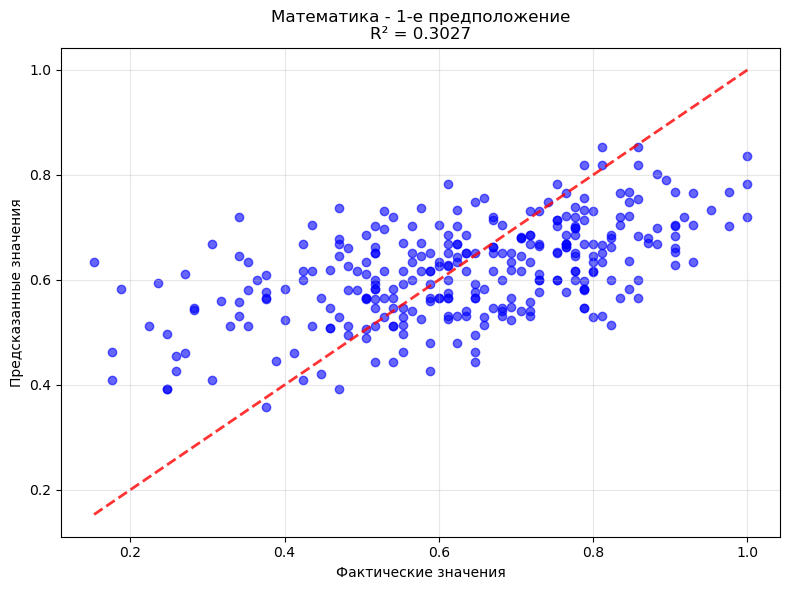

   R² = 0.3027

2. ЧТЕНИЕ - Независимая модель:


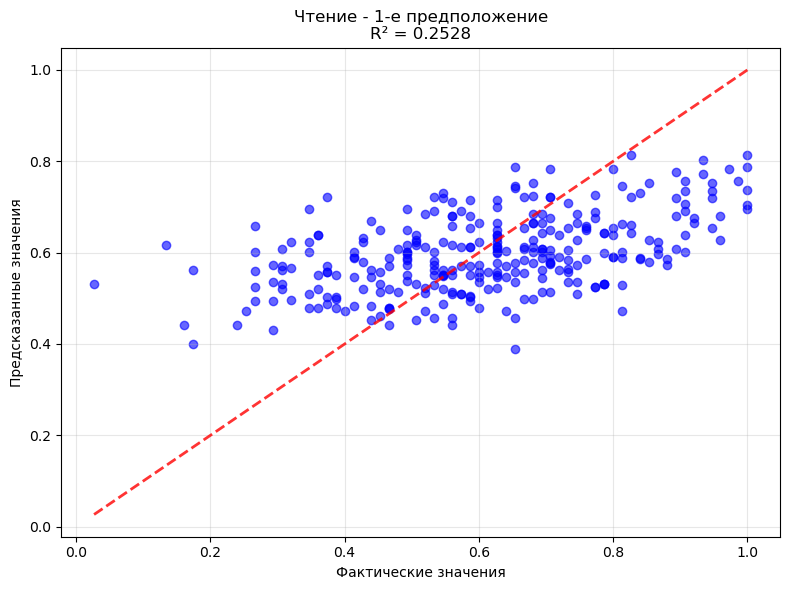

   R² = 0.2528

3. ПИСЬМО - Независимая модель:


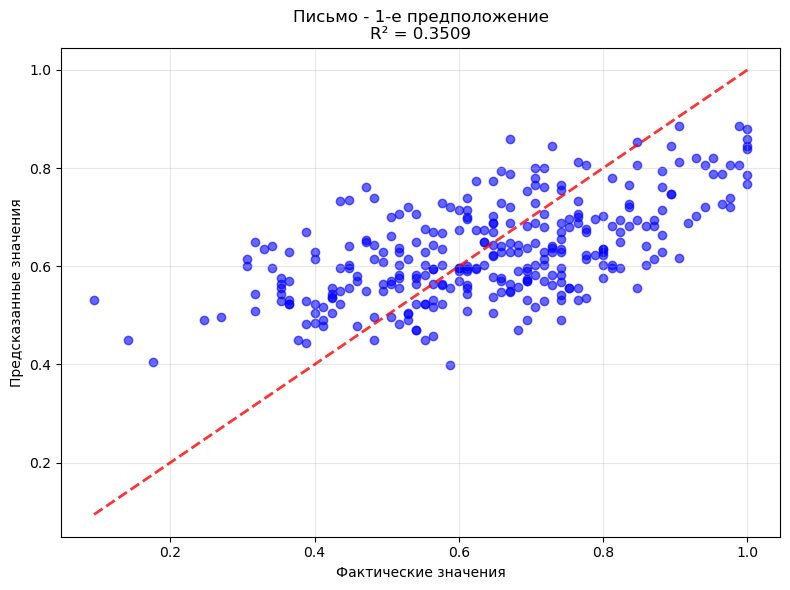

   R² = 0.3509

=== ОЦЕНКА МОДЕЛЕЙ ВТОРОГО ПРЕДПОЛОЖЕНИЯ ===

1. МАТЕМАТИКА - Зависимая модель:


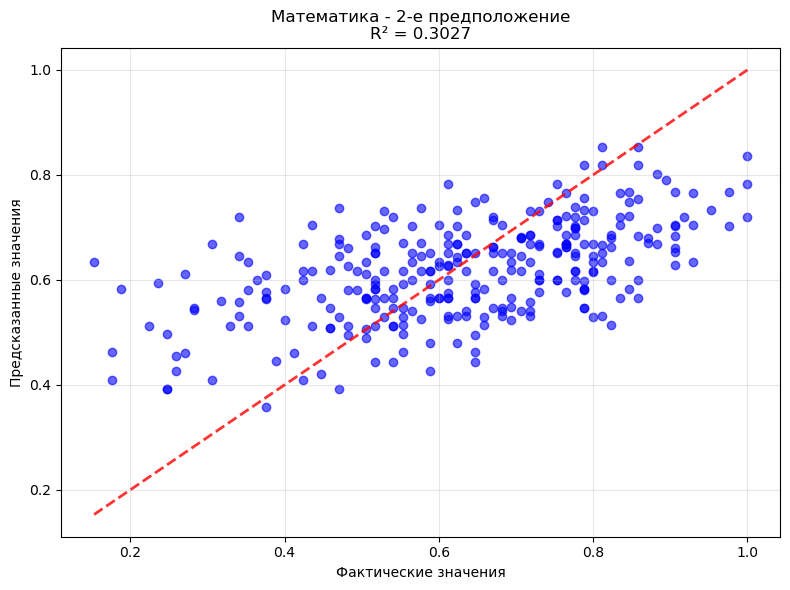

   R² = 0.3027

2. ЧТЕНИЕ - Зависимая модель:


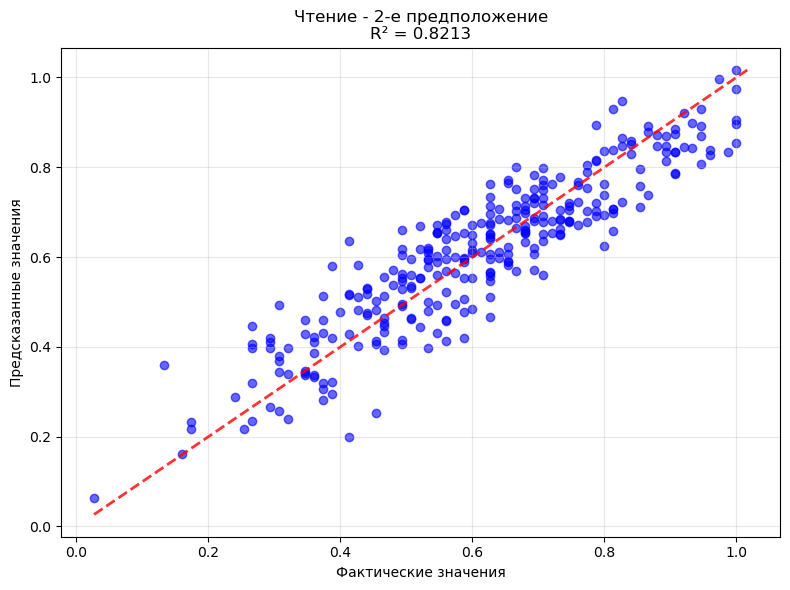

   R² = 0.8213

3. ПИСЬМО - Зависимая модель:


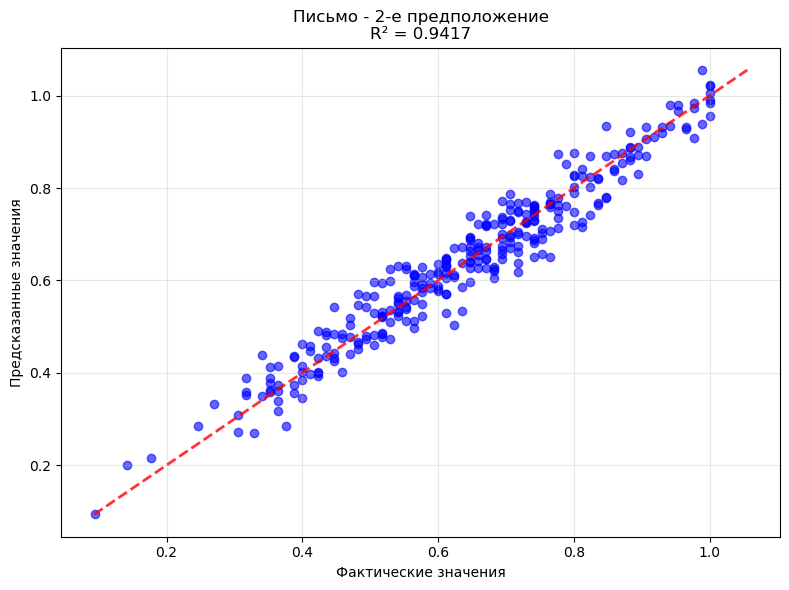

   R² = 0.9417


In [9]:
# =============================================================================
# ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ И ВИЗУАЛИЗАЦИЯ
# =============================================================================

print("ОЦЕНКА КАЧЕСТВА МОДЕЛЕЙ И ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("=" * 70)

def evaluate_model(x_test, y_test, beta, model_name):
    """Оценка качества модели и визуализация (только R²)"""
    import matplotlib.pyplot as plt
    
    # Вычисляем предсказания
    predictions = []    # Создаем пустой список для хранения предсказаний
    for i in range(len(x_test)):    # Проходим по всем тестовым наблюдениям
        pred = mult_predict(x_test[i], beta)   # Предсказываем значение для i-го наблюдения
        predictions.append(pred)    # Добавляем предсказание в список
    
    # Вычисляем R² 
    r_squared = mult_r_squared(x_test, y_test, beta)
    
    # Визуализация
    plt.figure(figsize=(8, 6))
    
    # График: предсказания vs фактические значения
    plt.scatter(y_test, predictions, alpha=0.6, color='blue')
    
    # Прямая (y = x)
    min_val = min(min(y_test), min(predictions))
    max_val = max(max(y_test), max(predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8, linewidth=2)
    
    # Настройки графика
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'{model_name}\nR² = {r_squared:.4f}')  # Только R² в заголовке
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"   R² = {r_squared:.4f}")
    
    return r_squared  


print("\n=== ОЦЕНКА МОДЕЛЕЙ ПЕРВОГО ПРЕДПОЛОЖЕНИЯ ===")

print("\n1. МАТЕМАТИКА - Независимая модель:")
x_test, y_test = prepare_data_for_evaluation(test_data, features_basic, "math")
r2_math_1 = evaluate_model(x_test, y_test, beta_math_1, "Математика - 1-е предположение")

print("\n2. ЧТЕНИЕ - Независимая модель:")
x_test, y_test = prepare_data_for_evaluation(test_data, features_basic, "reading")
r2_reading_1 = evaluate_model(x_test, y_test, beta_reading_1, "Чтение - 1-е предположение")

print("\n3. ПИСЬМО - Независимая модель:")
x_test, y_test = prepare_data_for_evaluation(test_data, features_basic, "writing")
r2_writing_1 = evaluate_model(x_test, y_test, beta_writing_1, "Письмо - 1-е предположение")

print("\n=== ОЦЕНКА МОДЕЛЕЙ ВТОРОГО ПРЕДПОЛОЖЕНИЯ ===")

print("\n1. МАТЕМАТИКА - Зависимая модель:")
x_test, y_test = prepare_data_for_evaluation(test_data, features_basic, "math")
r2_math_2 = evaluate_model(x_test, y_test, beta_math_2, "Математика - 2-е предположение")

print("\n2. ЧТЕНИЕ - Зависимая модель:")
x_test, y_test = prepare_data_for_evaluation(test_data, features_with_math, "reading")
r2_reading_2 = evaluate_model(x_test, y_test, beta_reading_2, "Чтение - 2-е предположение")

print("\n3. ПИСЬМО - Зависимая модель:")
x_test, y_test = prepare_data_for_evaluation(test_data, features_with_math_reading, "writing")
r2_writing_2 = evaluate_model(x_test, y_test, beta_writing_2, "Письмо - 2-е предположение")

In [10]:
# =============================================================================
# СРАВНИТЕЛЬНЫЙ АНАЛИЗ И ВЫВОДЫ
# =============================================================================

print("\n" + "=" * 70)
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ")
print("=" * 70)

print(f"\n{'МЕТРИКА':<25} {'1-е предположение':<20} {'2-е предположение':<20} {'ИЗМЕНЕНИЕ':<15}")
print("-" * 85)

# Математика
print(f"\n{'МАТЕМАТИКА':<25}")
print(f"{'  R²':<25} {r2_math_1:<20.4f} {r2_math_2:<20.4f} {r2_math_2 - r2_math_1:>+14.4f}")

# Чтение
print(f"\n{'ЧТЕНИЕ':<25}")
print(f"{'  R²':<25} {r2_reading_1:<20.4f} {r2_reading_2:<20.4f} {r2_reading_2 - r2_reading_1:>+14.4f}")

# Письмо
print(f"\n{'ПИСЬМО':<25}")
print(f"{'  R²':<25} {r2_writing_1:<20.4f} {r2_writing_2:<20.4f} {r2_writing_2 - r2_writing_1:>+14.4f}")

print("\n" + "=" * 70)
print("ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ")
print("=" * 70)

print("\n1. КАЧЕСТВО МОДЕЛЕЙ В ЦЕЛОМ:")
average_r2_1 = (r2_math_1 + r2_reading_1 + r2_writing_1) / 3
average_r2_2 = (r2_math_2 + r2_reading_2 + r2_writing_2) / 3

print(f"• Средний R² первого предположения: {average_r2_1:.4f}")
print(f"• Средний R² второго предположения: {average_r2_2:.4f}")

if average_r2_1 < 0.3:
    print("• Общее качество моделей: НИЗКОЕ (R² < 0.3)")
elif average_r2_1 < 0.6:
    print("• Общее качество моделей: СРЕДНЕЕ (0.3 ≤ R² < 0.6)")
elif average_r2_1 < 0.8:
    print("• Общее качество моделей: ХОРОШЕЕ (0.6 ≤ R² < 0.8)")
else:
    print("• Общее качество моделей: ОТЛИЧНОЕ (R² ≥ 0.8)")

print("\n2. ПРОВЕРКА ГИПОТЕЗ:")

print("\nГИПОТЕЗА 1: 'Математика не зависит от других экзаменов'")
if abs(r2_math_1 - r2_math_2) < 0.05:
    print("✓ ПОДТВЕРЖДЕНА: качество предсказания математики практически не изменилось")
    print("  Это логично, так как математика - первый экзамен")
else:
    print("✗ ОПРОВЕРГНУТА: качество предсказания математики значительно изменилось")

print("\nГИПОТЕЗА 2: 'Чтение зависит от результата по математике'")
if r2_reading_2 > r2_reading_1 + 0.05:
    print("✓ ПОДТВЕРЖДЕНА: добавление математики УЛУЧШИЛО предсказание чтения")
    print("  Студенты, хорошо сдавшие математику, способны хорошо сдавать чтение")
elif r2_reading_2 < r2_reading_1 - 0.05:
    print("✗ ОПРОВЕРГНУТА: добавление математики УХУДШИЛО предсказание чтения")
    print("  Это неожиданно и требует дополнительного исследования")
else:
    print("− НЕОПРЕДЕЛЕННО: добавление математики не оказало значительного влияния")

print("\nГИПОТЕЗА 3: 'Письмо зависит от результатов по математике и чтению'")
if r2_writing_2 > r2_writing_1 + 0.05:
    print("✓ ПОДТВЕРЖДЕНА: добавление математики и чтения УЛУЧШИЛО предсказание письма")
    print("  Навыки математики и чтения положительно влияют на письмо")
elif r2_writing_2 < r2_writing_1 - 0.05:
    print("✗ ОПРОВЕРГНУТА: добавление математики и чтения УХУДШИЛО предсказание письма")
else:
    print("− НЕОПРЕДЕЛЕННО: добавление признаков не оказало значительного влияния")

print("\n" + "=" * 70)
print("ЗАКЛЮЧЕНИЕ")
print("=" * 70)

confirmed_hypotheses = 0
if abs(r2_math_1 - r2_math_2) < 0.05:
    confirmed_hypotheses += 1
if r2_reading_2 > r2_reading_1 + 0.05:
    confirmed_hypotheses += 1
if r2_writing_2 > r2_writing_1 + 0.05:
    confirmed_hypotheses += 1

print(f"Подтверждено гипотез: {confirmed_hypotheses} из 3")

if confirmed_hypotheses >= 2:
    print("✓ Основная гипотеза исследования ПОДТВЕРЖДЕНА")
    print("  Результаты экзаменов действительно зависят от предыдущих результатов")
else:
    print("✗ Основная гипотеза исследования НЕ ПОДТВЕРЖДЕНА")
    print("  Результаты экзаменов слабо зависят от предыдущих результатов")


СРАВНИТЕЛЬНЫЙ АНАЛИЗ РЕЗУЛЬТАТОВ

МЕТРИКА                   1-е предположение    2-е предположение    ИЗМЕНЕНИЕ      
-------------------------------------------------------------------------------------

МАТЕМАТИКА               
  R²                      0.3027               0.3027                      +0.0000

ЧТЕНИЕ                   
  R²                      0.2528               0.8213                      +0.5685

ПИСЬМО                   
  R²                      0.3509               0.9417                      +0.5908

ИНТЕРПРЕТАЦИЯ РЕЗУЛЬТАТОВ

1. КАЧЕСТВО МОДЕЛЕЙ В ЦЕЛОМ:
• Средний R² первого предположения: 0.3021
• Средний R² второго предположения: 0.6886
• Общее качество моделей: СРЕДНЕЕ (0.3 ≤ R² < 0.6)

2. ПРОВЕРКА ГИПОТЕЗ:

ГИПОТЕЗА 1: 'Математика не зависит от других экзаменов'
✓ ПОДТВЕРЖДЕНА: качество предсказания математики практически не изменилось
  Это логично, так как математика - первый экзамен

ГИПОТЕЗА 2: 'Чтение зависит от результата по математике'
✓ ПОДТВЕ